In [43]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn import model_selection #методы разделения и валидации
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna


%matplotlib inline
plt.style.use('seaborn')

### Знакомство с данными и их исследование

In [2]:
data = pd.read_csv('_train_sem.csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Предварительная обработка не требуется, данные уже закодированы и нормализованы.

Смотрим на сбалансированность классов:

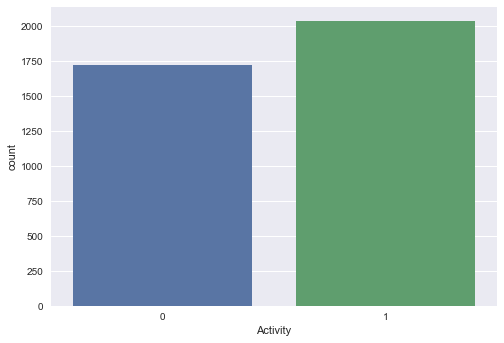

In [3]:
sns.countplot(data=data, x='Activity');

In [4]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

#### **Логистическая регрессия**

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [6]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)


#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=log_reg, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([4.33949661, 5.70807528, 5.02926922, 4.44978237, 5.20818377]),
 'score_time': array([0.03053379, 0.05083728, 0.02284598, 0.02540016, 0.02854061]),
 'test_score': array([0.78321678, 0.77791411, 0.77163462, 0.78553616, 0.77339901]),
 'train_score': array([0.88132417, 0.89595202, 0.89497717, 0.88775203, 0.8970321 ])}

In [7]:
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 0.89
Valid k-fold mean f1: 0.78


#### **Случайный лес**

In [8]:
#Создаём объект класса RandomForestClassifier
RFC = ensemble.RandomForestClassifier(
    n_estimators=100, #число деревьев
    criterion='entropy', #критерий эффективности
    max_depth=7, #максимальная глубина дерева
    min_samples_leaf=10,
    random_state=42 #генератор случайных чисел
)

#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=RFC, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([1.35851145, 1.19599366, 1.4504652 , 1.17434454, 1.16076851]),
 'score_time': array([0.04600215, 0.05199695, 0.04231   , 0.04435754, 0.04209948]),
 'test_score': array([0.77310924, 0.77435265, 0.75648949, 0.78371501, 0.78166466]),
 'train_score': array([0.82360487, 0.84654809, 0.83898828, 0.8422628 , 0.83343615])}

In [9]:
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 0.84
Valid k-fold mean f1: 0.77


### <center> **GridSearchCV**

Сделаем подбор гиперпараметров с помощью базового метода оптимизации GridSeachCV.

#### **Логистическая регрессия**

In [12]:
param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              'C': list(np.linspace(0.01, 10, 10, dtype=float))}

grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train)
y_train_pred = grid_search.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred))) 
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

Wall time: 48min 10s
f1_score на обучающем наборе: 0.82
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}


#### **Случайный лес**

In [13]:
param_grid = {'n_estimators': list(range(100, 200, 30)),
              'min_samples_leaf': [5,7],
              'max_depth': [10, 15, 20, 25]
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 
y_train_pred = grid_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

Wall time: 2min 26s
f1_score на обучающем наборе: 0.93
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 7, 'n_estimators': 130}


### <center> **RandomizedSearchCV**

Сделаем подбор гиперпараметров с помощью базового метода оптимизации RandomizedSeachCV.

#### **Логистическая регрессия**

In [15]:
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
              'C': list(np.linspace(0.01, 10, 10, dtype=float))},

            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train)
y_train_pred = random_search.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

Wall time: 14min 40s
f1_score на обучающем наборе: 0.90
f1_score на тестовом наборе: 0.77
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 2.23}


#### **Случайный лес**

In [16]:
param_distributions = {'n_estimators': list(range(100, 200, 30)),
              'min_samples_leaf': [5,7],
              'max_depth': [10, 15, 20, 25]
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

Wall time: 54.3 s
f1_score на обучающем наборе: 0.93
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'n_estimators': 130, 'min_samples_leaf': 7, 'max_depth': 25}


Метрику удалось еще больше улучшить с помощью обоих методов, но RandomizedSearchCV потребовалось более,чем в два раза меньше времени;

#### **Вывод по базовой оптимизации:**
Продемонстрирована более эффективная и быстрая работа RandomizedSearchCV над GridSearchCV.

### <center> Hyperopt

Сделаем подбор гиперпараметров с помощью продвинутого метода оптимизации Hyperopt.

#### **Логистическая регрессия**

In [33]:
# зададим пространство поиска гиперпараметров
space={'penalty': hp.choice('penalty', ('l2', 'none')) ,
       'solver': hp.choice('solver', ('lbfgs', 'sag')),
       'C': hp.uniform('C', 0.01, 10)}

In [34]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'], 
              'solver': params['solver'],
              'C': params['C']
              }
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state)
    
    # обучаем модель с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [35]:
%%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [02:33<00:00,  7.68s/trial, best loss: -0.7691438578131198]
Наилучшие значения гиперпараметров {'C': 1.7269968983516413, 'penalty': 0, 'solver': 1}
Wall time: 2min 33s


In [47]:
model = linear_model.LogisticRegression(random_state=random_state,
                                    penalty='l2',
                                    solver='sag',
                                    C=1.727
                                    )

#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=RFC, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)

print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 0.84
Valid k-fold mean f1: 0.77


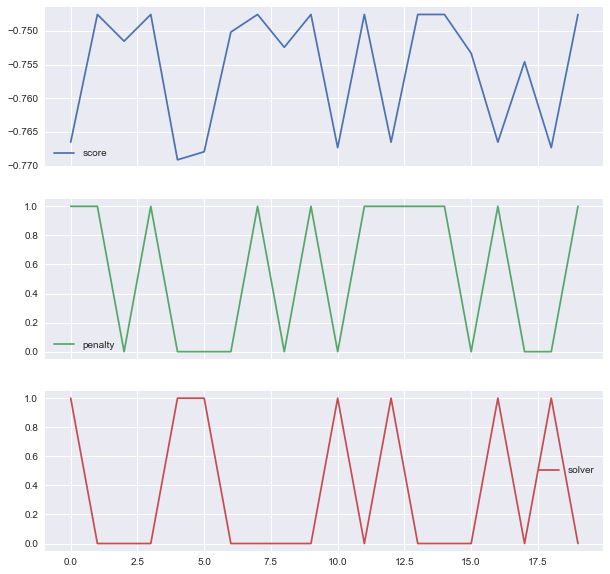

In [48]:
# отрисуем, как менялась метрика при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['penalty'][0],
                      x['misc']['vals']['solver'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'penalty', 'solver'])
# возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

#### **Случайный лес**

In [49]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 300, 10),
       'max_depth' : hp.quniform('max_depth', 15, 40, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 3, 7, 1)
      }

In [50]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)
    
    # обучаем модель с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [51]:
%%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [03:09<00:00,  9.50s/trial, best loss: -0.8097798646226206]
Наилучшие значения гиперпараметров {'max_depth': 22.0, 'min_samples_leaf': 3.0, 'n_estimators': 200.0}
Wall time: 3min 9s


In [54]:
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)

#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)

print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 0.98
Valid k-fold mean f1: 0.81


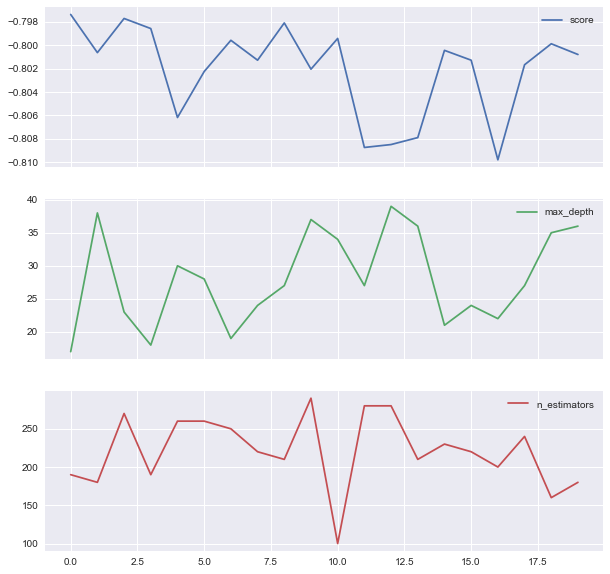

In [55]:
# отрисуем, как менялась метрика при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators'])
# возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

## <center> Optuna

Сделаем подбор гиперпараметров с помощью продвинутого метода оптимизации Optuna.

#### **Логистическая регрессия**

In [58]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  
  penalty=trial.suggest_categorical('penalty', ('l2', 'none')) 
  solver=trial.suggest_categorical('solver', ('lbfgs', 'sag'))
  C=trial.suggest_float('C', 0.01, 10)

  # создаем модель
  model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver)
  # обучаем модель
  score =cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

In [59]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-08-04 17:20:07,997] A new study created in memory with name: LogisticRegression
[I 2022-08-04 17:20:25,930] Trial 0 finished with value: 0.7714948983270105 and parameters: {'penalty': 'none', 'solver': 'sag', 'C': 2.2739149563720646}. Best is trial 0 with value: 0.7714948983270105.
[I 2022-08-04 17:20:43,789] Trial 1 finished with value: 0.7761786690106385 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 0.6431321497777371}. Best is trial 1 with value: 0.7761786690106385.
[I 2022-08-04 17:20:49,088] Trial 2 finished with value: 0.7583522396374635 and parameters: {'penalty': 'none', 'solver': 'lbfgs', 'C': 5.480384375418532}. Best is trial 1 with value: 0.7761786690106385.
[I 2022-08-04 17:21:06,572] Trial 3 finished with value: 0.7711501311532194 and parameters: {'penalty': 'none', 'solver': 'sag', 'C': 4.730605219605068}. Best is trial 1 with value: 0.7761786690106385.
[I 2022-08-04 17:21:12,133] Trial 4 finished with value: 0.7739527748192833 and parameters: {'penalty'

Wall time: 5min 9s


In [61]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'sag', 'C': 1.2349120393424913}
f1_score на обучающем наборе: 0.78


In [62]:
# рассчитаем метрику для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params,random_state=random_state, )
print("f1_score на тестовом наборе: {:.2f}".format(cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()))

f1_score на тестовом наборе: 0.78


Используем диаграмму, чтобы проверить, идет ли оптимизация гиперпараметров в правильном направлении или нет.

In [63]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

Все идет верно, метрика максимизируется.

График важности гиперпараметров - помогает понять, какие гиперпараметры вносят больший вклад в минимизацию/максимизацию метрики.

In [64]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

Из этого графика можно сделать вывод, что стоит обратить большее внимание на настройку гиперпараметра  penalty.

График контура отношений гиперпараметров

In [65]:
optuna.visualization.plot_contour(study, params=["penalty", "solver"],
                                  target_name="f1_score")

Точки с белым фоном это и есть лучшии комбинации solver, penalty.

#### **Случайный лес**

In [66]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 300, 10)
  max_depth = trial.suggest_int('max_depth', 15, 40, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 7, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  score =cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

  return score
  

In [68]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study1 = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study1.optimize(optuna_rf, n_trials=20)

[I 2022-08-04 17:36:37,740] A new study created in memory with name: RandomForestClassifier
[I 2022-08-04 17:36:44,714] Trial 0 finished with value: 0.8005884546005154 and parameters: {'n_estimators': 130, 'max_depth': 28, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8005884546005154.
[I 2022-08-04 17:36:53,648] Trial 1 finished with value: 0.8066726232488254 and parameters: {'n_estimators': 140, 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8066726232488254.
[I 2022-08-04 17:37:09,142] Trial 2 finished with value: 0.8151351589319347 and parameters: {'n_estimators': 260, 'max_depth': 40, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8151351589319347.
[I 2022-08-04 17:37:19,148] Trial 3 finished with value: 0.8039183232764782 and parameters: {'n_estimators': 200, 'max_depth': 32, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8151351589319347.
[I 2022-08-04 17:37:30,299] Trial 4 finished with value: 0.8061472150216398 and parameters: {'n_

Wall time: 4min 22s


In [69]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study1.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study1.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 210, 'max_depth': 19, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.82


In [70]:
# рассчитаем метрику для тестовой выборки
model = ensemble.RandomForestClassifier(**study1.best_params,random_state=random_state, )
print("f1_score на тестовом наборе: {:.2f}".format(cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()))

f1_score на тестовом наборе: 0.82


Используем диаграмму, чтобы проверить, идет ли оптимизация гиперпараметров в правильном направлении или нет.

In [71]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

Все идет верно, метрика макисмизируется

Посмотрим на важность параметров

In [72]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

Судя по гистограмме, самым важным параметром является min_samples_leaf

График контура отношений гиперпараметров

In [73]:
optuna.visualization.plot_contour(study, params=["max_depth", "n_estimators"],
                                  target_name="f1_score")

**Вывод:**

Наилучшую метрику удалось получить с гиперпараметрами, подобранными с помощью методов:

**Optuna**

Логистическая регрессия:

f1 на тестовой выборке - 0.78

Случайный лес:

f1 на тестовой выборке - 0.82

**GridSearchCV**

Логистическая регрессия:

f1 на тестовой выборке - 0.80

Случайный лес:

f1 на тестовой выборке - 0.82

Но время подбора параметров значительно уступает методу Optuna.

Для сравнения: метрика, полученная без применения методов подбора гипераметров:

Логистическая регрессия:

f1 на тестовой выборке - 0.78

Случайный лес:

f1 на тестовой выборке - 0.77